# Prior and Posterior

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import arviz as az

plt.rcParams['figure.dpi'] = 75

In [2]:
from os.path import basename, exists
from urllib.parse import urlparse

def download(url, filename=None):    
    parsed_url = urlparse(url)
    if filename is None:
        filename = basename(parsed_url.path) 
    
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    

In [3]:
def make_cdf(seq, name=""):
    series = pd.Series(seq)
    cdf = series.value_counts(normalize=True).sort_index().cumsum()
    cdf.name = name
    return cdf

In [4]:
def plot_prior(trace):
    return pm.plot_posterior(trace, group='prior');

## The Beta-Binomial model

Let's see what A/B testing looks like in PyMC.
In digital marketing, A/B testing is used to evaluate the effect of different versions of an ad, web page, etc. 
But more generally, it has the same structure as tests of medical treatments, educational interventions, etc.

As an example, suppose we test an email campaign that includes a promotional offer.
We send the A version to 100 people, and 8 of them accept the offer.
So the observed conversion rate in this sample is 8%.

Here's a dictionary that represents these results.

In [5]:
A = dict(n=100, k=8)

And here's a PyMC model that uses these results to estimate the true conversion rate -- that is, the rate we expect if we sent the email to the entire target population.

Exercise: Fill in this model with a Beta prior and the observed data.

In [6]:
# Fill this in

with pm.Model() as model_signups:
    # Prior
    conversion_rate = 0
    # Likelihood
    pm.Binomial("n_signups", p=conversion_rate, n=1)

In [7]:
# Solution

with pm.Model() as model_signups:
    # Prior
    conversion_rate = pm.Beta("conversion_rate", 2, 5)
    # Likelihood
    pm.Binomial("n_signups", p=conversion_rate, n=A['n'], observed=A['k'])

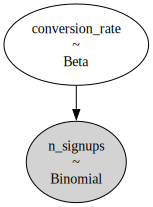

In [8]:
pm.model_to_graphviz(model_signups)

Let's draw a sample from the prior distribution.

In [9]:
with model_signups:
    prior_samples = pm.sample_prior_predictive()

Sampling: [conversion_rate, n_signups]


The prior is weakly informative, biased toward lower values, based on domain knowledge that conversion rates are seldom higher than 60%

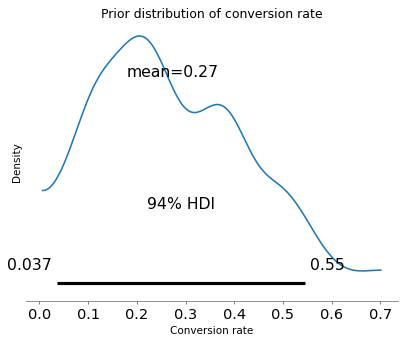

In [10]:
ax = plot_prior(prior_samples)
ax.set(
    xlabel="Conversion rate",
    ylabel="Density",
    title="Prior distribution of conversion rate",
);

Along with the prior distribution of the conversion rate, the also get a sample from the **prior predictive** distribution, which shows the number of conversions we would get from 100 emails, assuming that the conversion rate follows the prior distribution.

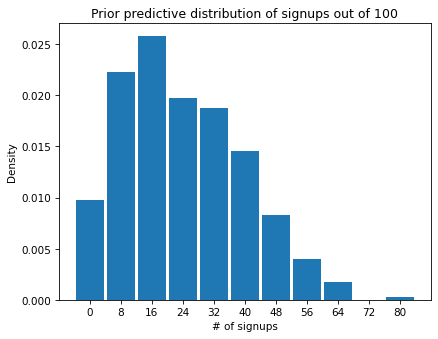

In [11]:
ax = pm.plot_dist(prior_samples.prior_predictive["n_signups"])
ax.set(
    xlabel="# of signups",
    ylabel="Density",
    title="Prior predictive distribution of signups out of 100",
);

The prior predictive distribution is quite wide, because it represents the uncertainty in the weak prior PLUS the variation we expect in a sample of 100 emails.

Now let's sample from the posterior.

In [12]:
with model_signups:
    # Sample from the Posterior
    trace_A = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Models like this generally sample well, but just to make sure, we can look at the trace plots.

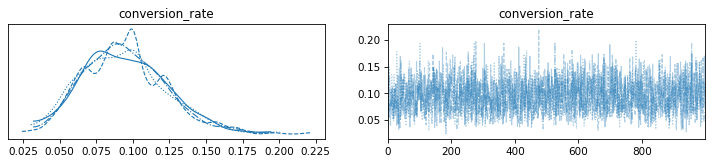

In [13]:
az.plot_trace(trace_A);

And check the diagnostic statistics.

In [14]:
pm.summary(trace_A)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
conversion_rate,0.094,0.028,0.042,0.146,0.001,0.0,1830.0,2167.0,1.0


Here's what the posterior distribution looks like.

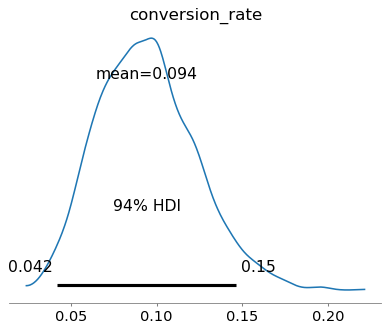

In [15]:
az.plot_posterior(trace_A);

It's centered near the observed conversion rate (8%) -- and it is still fairly wide, because the sample size is not very big.

To compare the prior and predictive distributions, we'll combine `trace_A` and `prior_samples`.

In [16]:
with model_signups:
    trace_A.extend(prior_samples)

And then we can use `plot_dist_comparison`.

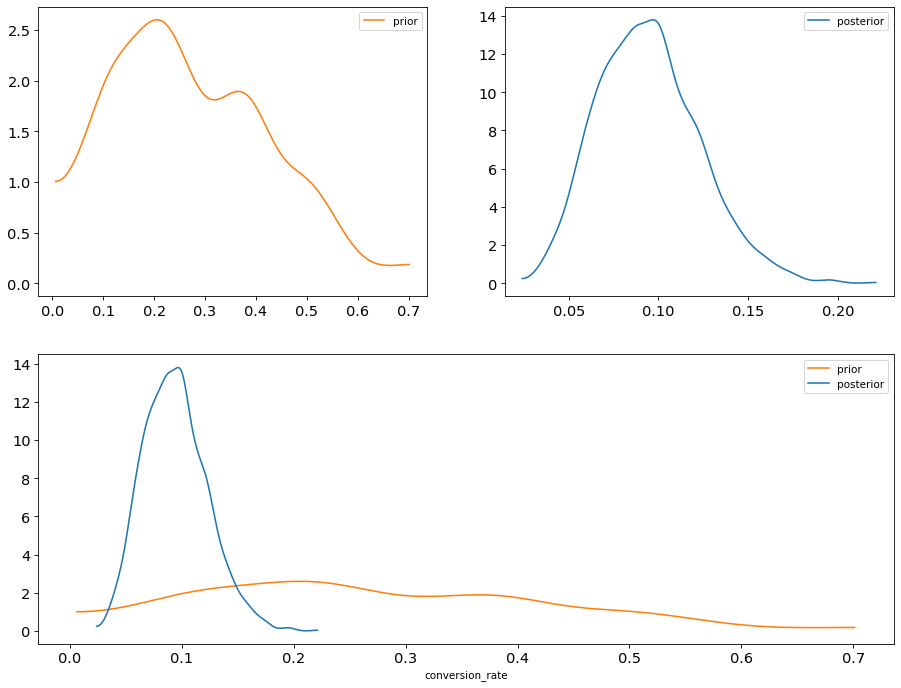

In [17]:
pm.plot_dist_comparison(trace_A);

Now suppose we send the same email to a different sample of 100 potential customers.
How many conversions do we expect?

The answer to this question is the **posterior predictive** distribution, which we can sample like this.

In [18]:
with model_signups:
    posterior_predictives = pm.sample_posterior_predictive(trace_A)
    trace_A.extend(posterior_predictives)

Sampling: [n_signups]


Output()

Here's what it looks like, compared to the prior predictive.

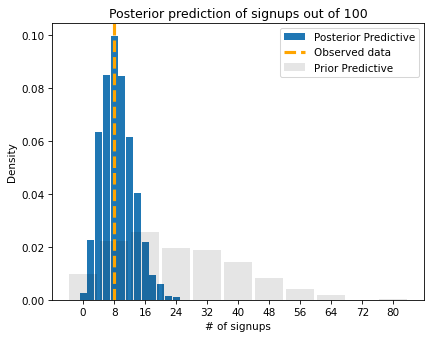

In [19]:
ax = pm.plot_dist(
    trace_A.posterior_predictive["n_signups"],
    label="Posterior Predictive",
)
ax.axvline(
    trace_A.observed_data["n_signups"],
    ls="--",
    lw=3,
    color="orange",
    label="Observed data",
)
pm.plot_dist(
    trace_A.prior_predictive["n_signups"],
    label="Prior Predictive",
    color="black",
    hist_kwargs={"alpha": 0.1},
    ax=ax,
)
ax.set(
    xlabel="# of signups",
    ylabel="Density",
    title="Posterior prediction of signups out of 100",
)
ax.legend();

The posterior predictive distribution is narrower than the prior predictive, because it is informed by the data.
But it still combines our remaining uncertainty about the conversion rate with the unpredictability of the next sample.

In summary:

* Prior distribution represents what we believe about the conversion rate before seeing the data. In this example, it's a continuous probability.

* Prior predictive distribution represents the prior uncertainty about the conversion rate AND the uncertain outcome of an experiment with a finite sample. In this example, it's discrete, because the data are discrete.

* Posterior distribution represents what we believe about the conversion rate after seeing the data (and it's continuous).

* The posterior predictive distribution represents the distribution of outcomes we expect if we run the same experiment again.

## A/B Testing

Now suppose we make a B version of the email promotion, send it to `50` people, and get `6` conversions.
Here's the same data.

In [20]:
B = dict(n=50, k=6)

And here's the same model with the new data.

In [21]:
with pm.Model() as model_B:
    # Prior
    conversion_rate = pm.Beta("conversion_rate", 2, 5)
    # Likelihood
    obs = pm.Binomial("obs", p=conversion_rate, n=B['n'], observed=B['k'])
    # Sample
    trace_B = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [conversion_rate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Rather than rebuild the model, we could use `pm.Data` and `pm.set_data`, but let's keep it simple for now.

Here's the posterior distribution.

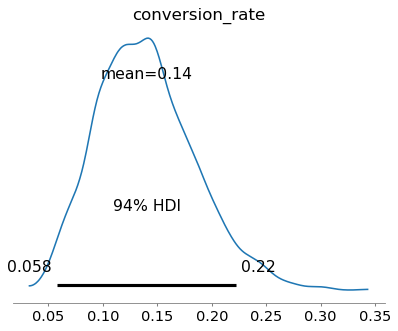

In [22]:
pm.plot_posterior(trace_B);

To compare the results from the two models, we can use a "forest plot", where each line shows the mean, 94% HDI, and 50% HDI. 

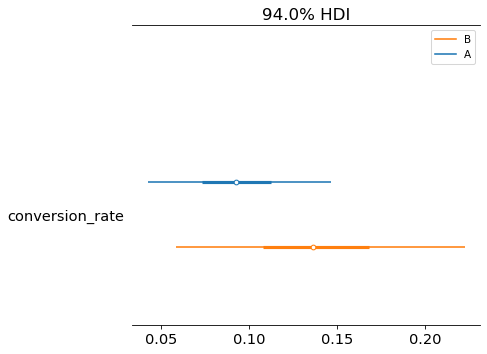

In [23]:
az.plot_forest(
    [trace_A, trace_B],
    model_names=["A", "B"],
    combined=True,
);

Based on these results, it looks like B is better, but the distributions overlap, so we might be tempted to run a hypothesis test.
But rather than say "yes, there's a difference" or "no, there isn't", it is more useful to compute the distribution of possible differences.

In [24]:
diff = trace_B.posterior["conversion_rate"] - trace_A.posterior["conversion_rate"]

Here's what it looks like.

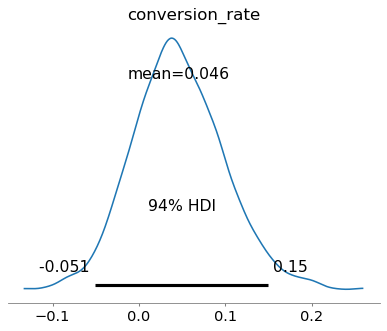

In [25]:
pm.plot_posterior(diff);

On average, we think B is better by about 5 percentage points, but it could plausibly be as much as 14 points.
On the other hand, it's still possible that A is better by 6 points.

And overall there's about a 19% chance that A is actually better.

In [26]:
(diff.values < 0).mean()

0.188

Topic for discussion: how can we use this information to make decisions?

### The Rookie Problem



Here's a problem from Chapter 4 of [Think Bayes](https://allendowney.github.io/ThinkBayes2/chap04.html#exercises)

> In Major League Baseball, most players have a batting average between .220 and .280, which means that their probability of getting a hit is between 0.22 and 0.38.
>
>Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?

And here's a model that estimates a proportion after observing `k=3` successes out of `n=3` attempts.
It uses a Binomial likelihood, which depends only on the number of successes and attempts, rather than the Bernoulli likelihood, which uses the entire sequence of hits and misses.

In [27]:
with pm.Model() as rookie_model:
    p = pm.Beta('p', alpha=2, beta=2)  
    obs = pm.Binomial('obs', n=3, p=p, observed=3)
    trace = pm.sample(500, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Here's the posterior.

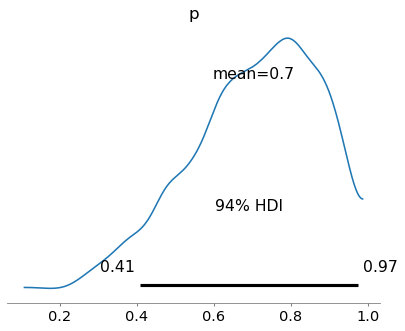

In [28]:
pm.plot_posterior(trace, var_names=['p']);


In this case, letting the data speak for itself yields an unrealistic result.
We have a lot of information about batting averages in the major leages, which we can use to choose a more reasonable prior.

Again, we can specify the prior in terms of mean and dispersion, and convert to the parameters of the Beta distribution.

In [29]:
mean = 0.250  # Mean batting average
std = 0.030  # Standard deviation

# Compute alpha and beta
alpha = mean * ((mean * (1 - mean)) / std**2 - 1)
beta = (1 - mean) * ((mean * (1 - mean)) / std**2 - 1)

alpha, beta

(51.833333333333336, 155.5)

Or we can take advantage of the alternative parameterization.

In [30]:
with pm.Model() as rookie_model:
    # p = pm.Beta('p', alpha=alpha, beta=beta)
    p = pm.Beta('p', mu=mean, sigma=std) 
    obs = pm.Binomial('obs', n=3, p=p, observed=3)
    prior_trace = pm.sample_prior_predictive(1000, random_seed=123)

Sampling: [obs, p]


Here's what that prior looks like (confusingly, we can use `plot_posterior` to plot priors).

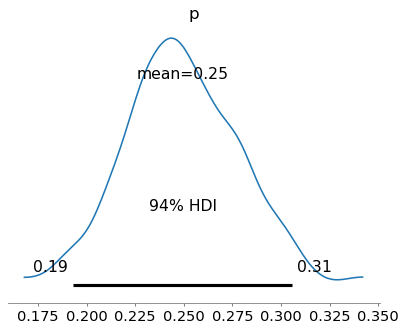

In [31]:
# plot the prior
pm.plot_posterior(prior_trace, group='prior');

In [32]:
with rookie_model:
    trace = pm.sample(1000, random_seed=123)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


And here's the posterior.

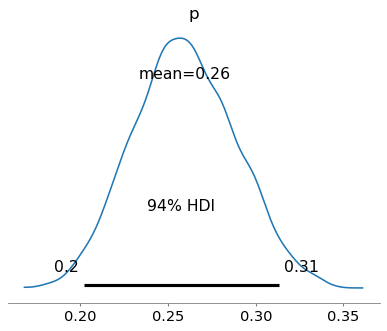

In [33]:
pm.plot_posterior(trace, var_names=['p']);

With a strongly informative prior, the outcome of three at bats barely moves the needle.